In [41]:
# 安装包
# !pip install scikit-plot
# import scikitplot.plotters as skplt

# !pip install -U sentence-transformers
# from sentence_transformers import SentenceTransformer, util


In [54]:
import scikitplot as skplt
from sentence_transformers import SentenceTransformer, util

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import nltk

# nltk.download('punkt')
# nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation

from pprint import pprint;
import pickle

import warnings

warnings.filterwarnings("ignore")

import pandas as pd

pd.set_option('display.max_colwidth', None)

import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

print("\n\n 库已加载！")




 库已加载！


In [43]:
# ## Open data connection to Drive ##
# from google.colab import drive
# drive.mount('/content/gdrive')

In [44]:
# df = pd.read_csv('/content/gdrive/MyDrive/SpamDetection/data/spam.csv', skiprows=1, names=['label', 'message'], encoding="ISO-8859-1")

In [55]:
df = pd.read_csv('D:\GraduationDesign\sms-spam-detector\data\spam.csv', skiprows=1, names=['label', 'message'],
                 encoding="ISO-8859-1")

Dataset size:  (4869, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives around here though"
4,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Ã¥Â£1.50 to rcv"
5,ham,Even my brother is not like to speak with me. They treat me like aids patent.
6,ham,"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."
7,ham,I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.
8,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
9,spam,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL"


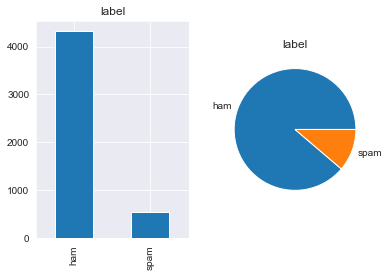

In [56]:
# 去除缺失值，去除重复项
df = df.dropna(how='all').reset_index(drop=True)  # 删除所有值为NaN的行
df = df.drop_duplicates(subset=['message'], keep=False).reset_index(drop=True)  # 删除内容重复的行

_, ax = plt.subplots(1, 2)
df['label'].value_counts().plot(ax=ax[0], kind="bar", rot=90, title='label');
df['label'].value_counts().plot(ax=ax[1], kind="pie", rot=90, title='label', ylabel='');
print("Dataset size: ", df.shape)

df.head(10)

In [57]:
# 创建一些函数，处理西班牙语
stemmer = SnowballStemmer('english')


def stem_tokens(tokens, stemmer):
    stems = []
    for token in tokens:
        stems.append(stemmer.stem(token))
    return stems


# def tokenize(text):
#     text = ''.join([s for s in text if s not in non_words])
#     tokens = word_tokenize(text)
#     return tokens


def tokenize_stem(text):
    text = ''.join([s for s in text if s not in non_words])
    tokens = word_tokenize(text)
    tokens = stem_tokens(tokens, stemmer)
    return tokens


# 准备标点列表
non_words = list(punctuation)
non_words.extend(map(str, range(10)))
print("Symbols to be removed (%d):" % len(non_words), non_words)

# 准备英语停顿词列表
english_stopwords = stopwords.words('english')
print("Stop-words to be removed (%d):" % len(english_stopwords), english_stopwords)

Symbols to be removed (42): ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Stop-words to be removed (179): ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',

In [59]:
# 创建BoW、TFIDF编码器
bow = CountVectorizer(
    analyzer='word',
    # ngram_range = (1, 2),
    strip_accents='ascii',
    tokenizer=tokenize_stem,
    lowercase=True,
    stop_words=english_stopwords,
    max_features=512,  # We set the same dim as BERT
)
tfidf = TfidfVectorizer(
    analyzer='word',
    # ngram_range = (2, 2),
    strip_accents='ascii',
    tokenizer=tokenize_stem,
    lowercase=True,
    stop_words=english_stopwords,
    max_features=512,
)

print("BoW和TFIDF编码器创建完成!")


BoW和TFIDF编码器创建完成!


In [60]:
# 创建BERT编码器
model = SentenceTransformer('D:\GraduationDesign\sms-spam-detector\sentence-transformers\distiluse-base-multilingual-cased-v1')
print("\n\nBERT 预训练模型加载完成!")



BERT 预训练模型加载完成!


In [61]:
# 使用部分数据快速尝试两个编码器
N_data = 1000
bow_vecs = bow.fit_transform(df['message'][:N_data])
tfidf_vecs = tfidf.fit_transform(df['message'][:N_data])

df_bow = pd.DataFrame(data=bow_vecs.todense(), columns=bow.get_feature_names())
df_tfidf = pd.DataFrame(data=tfidf_vecs.todense(), columns=tfidf.get_feature_names())
display(df_bow.head(), df_tfidf.head())
print("BoW data size: ", bow_vecs.shape)
print("TFIDF data size: ", tfidf_vecs.shape)
print("Vocabulary: ", bow.get_feature_names())


,aa,abiola,abl,abt,account,actual,address,aft,afternoon,age,...,xxx,ya,yeah,year,yes,yesterday,yet,yo,youll,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,aa,abiola,abl,abt,account,actual,address,aft,afternoon,age,...,xxx,ya,yeah,year,yes,yesterday,yet,yo,youll,yup
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.264365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.365192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


BoW data size:  (1000, 512)
TFIDF data size:  (1000, 512)
Vocabulary:  ['aa', 'abiola', 'abl', 'abt', 'account', 'actual', 'address', 'aft', 'afternoon', 'age', 'ago', 'ah', 'ahead', 'aight', 'alreadi', 'alright', 'also', 'alway', 'amp', 'ani', 'anoth', 'anymor', 'anyon', 'anyth', 'anytim', 'anyway', 'appli', 'ard', 'around', 'ask', 'avail', 'award', 'awesom', 'b', 'babe', 'babi', 'back', 'bad', 'bank', 'bath', 'beauti', 'becaus', 'bed', 'befor', 'believ', 'best', 'better', 'big', 'birthday', 'bit', 'blue', 'book', 'bore', 'box', 'boy', 'boytoy', 'break', 'bring', 'brother', 'bus', 'busi', 'buy', 'c', 'call', 'camera', 'cant', 'car', 'card', 'care', 'carlo', 'case', 'cash', 'catch', 'caus', 'chang', 'charg', 'chat', 'check', 'choos', 'claim', 'class', 'close', 'club', 'code', 'coffe', 'collect', 'colleg', 'come', 'compani', 'confirm', 'contact', 'content', 'cool', 'cos', 'cost', 'could', 'credit', 'current', 'custom', 'cut', 'da', 'daddi', 'dat', 'date', 'day', 'dear', 'decid', 'delive

In [62]:
# 辅助函数构建BERT编码器
def bert_transform(data, encoder):
    print("\n\n使用BERT模型编码中... ")
    data_vecs = []
    for i, d in enumerate(data):
        data_vec = encoder.encode(d)
        data_vecs.append(data_vec)
        print(".", end="" if (i % 100 > 0) else ("%4d\n" % i))
    return data_vecs


print("BERT编码函数已加载!")

BERT编码函数已加载!


In [63]:
bert_vecs = bert_transform(df['message'][:N_data], model)



使用BERT模型编码中... 
.   0
.................................................................................................... 100
.................................................................................................... 200
.................................................................................................... 300
.................................................................................................... 400
.................................................................................................... 500
.................................................................................................... 600
.................................................................................................... 700
.................................................................................................... 800
.................................................................................................... 900
...............................

In [64]:
print(np.array(bert_vecs[:100]))

[[ 0.06130195 -0.06372955 -0.00082987 ... -0.00184449 -0.03381245
  -0.01471525]
 [ 0.03902779 -0.01461547 -0.04566919 ... -0.04228596 -0.05330309
  -0.05416488]
 [ 0.0999884   0.05485659  0.00209512 ... -0.05873078 -0.00295677
   0.01296227]
 ...
 [ 0.00704428  0.00982639  0.00021904 ... -0.0132974   0.03939932
   0.01219583]
 [-0.09050376  0.03028554 -0.0430188  ... -0.079403   -0.04784489
   0.0655646 ]
 [ 0.02162633 -0.0141799   0.02232685 ... -0.01817576 -0.02548216
  -0.03237547]]


In [70]:
# 数据编码可视化函数
def show_embeddings(data_vecs):
    n_rows = len(data_vecs)
    fig, axs = plt.subplots(nrows=n_rows, sharex=True, figsize=(8, 3 * n_rows))

    for i, key in enumerate(data_vecs.keys()):
        encode_name = ("Encoder: %s") % key
        sns.heatmap(1 - data_vecs[key], ax=axs[i]).set_title(encode_name);

In [71]:
spam_vecs = defaultdict(list)
spam_vecs["BoW"] = bow_vecs.todense().A  # matrix->array
spam_vecs["TFIDF"] = tfidf_vecs.todense().A
spam_vecs["BERT"] = np.array(bert_vecs)

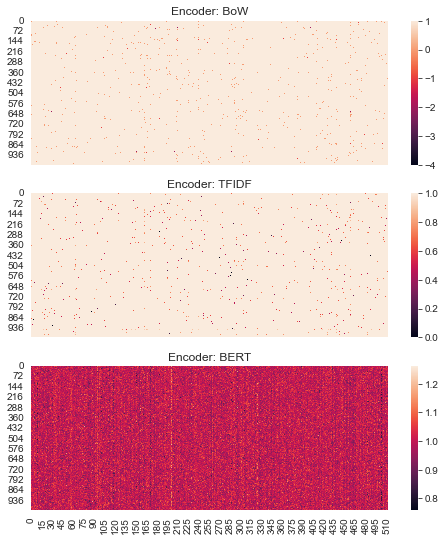

In [72]:
# 绘制三种编码器的热力图，BoW和TFIDF稀疏，而BERT稠密
show_embeddings(spam_vecs)

In [73]:
classifiers = [
    GaussianNB(),
    SVC(),
    LinearSVC(),
    LogisticRegression(),
    SGDClassifier(),
    KNeighborsClassifier(),
    MLPClassifier(),
]
print("分类器模型已加载!")

分类器模型已加载!


In [74]:
# 拟合分类器并返回指标
def train_test_clf(clf, X_train, y_train, X_test, y_test, tag="", isShow=False):
    """
    Args:
        clf:     分类器对象
        X_train: 训练数据编码值
        y_train: 训练数据标签
        X_test:  测试数据编码值
        y_test:  测试数据标签
    """
    # 拟合分类器
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # 计算分类器评估值
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='spam')

    # 打印评估值
    print('{:<36s} Balanced accuracy: {:.2f}%'.format(tag, bacc * 100))
    if isShow:
        skplt.plot_confusion_matrix(y_test, y_pred, title=tag + 'BAcc: {0:.2f}%'.format(bacc * 100),
                                    normalize=False, x_tick_rotation='vertical');
        plt.show()

    return acc, bacc, prec, recall, f1


print("训练函数已加载!")

训练函数已加载!


In [75]:
# 查看分类器泛化能力
def test_clf(clf, X_test, y_test, tag="", isShow=False):
    """
    Args:
        clf:     预训练分类器对象
        X_test:  测试数据编码
        y_test:  测试数据标签
    """
    # 模型预测
    y_pred = clf.predict(X_test)

    ## Compute classification metrics ##
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='spam')

    # 打印结果
    print('{:<36s} Balanced accuracy: {:.2f}%'.format(tag, bacc * 100))
    if isShow:
        skplt.plot_confusion_matrix(y_test, y_pred, title=tag + 'BAcc: {0:.2f}%'.format(bacc * 100),
                                    normalize=False, x_tick_rotation='vertical');
        plt.show()

    return acc, bacc, prec, recall, f1


print("测试函数已加载!")

测试函数已加载!


In [83]:
# 8：2划分数据集为训练集和测试集
def split_dataset(df, n_data=100, isShow=False):
    Train, Test, y_Train, y_Test = train_test_split(df['message'][:n_data],
                                                    df['label'][:n_data],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0) # random_state=0每次分割得到不同的数组，1每次得到相同的数组
    # 打印数据比例
    if isShow:
        _, ax = plt.subplots(1, 2)
        y_Train.value_counts().plot(ax=ax[0], kind='pie', figsize=(8, 8),
                                    autopct=lambda x: "%d" % round(y_Train.shape[0] * x / 100),
                                    ylabel='', title='Development')
        y_Test.value_counts().plot(ax=ax[1], kind='pie', figsize=(8, 8),
                                   autopct=lambda x: "%d" % round(y_Test.shape[0] * x / 100),
                                   ylabel='', title='Hold-out')
        plt.show()
        display("训练集内容:", Train.to_frame().head(5))
        display("测试集内容:", Test.to_frame().head(5))
        print("训练集形状（内容/标签）: ", Train.shape, y_Train.shape)
        print("测试集形状（内容/标签）: ", Test.shape, y_Test.shape)

    return Train, Test, y_Train, y_Test


print("分割函数已加载!")

分割函数已加载!


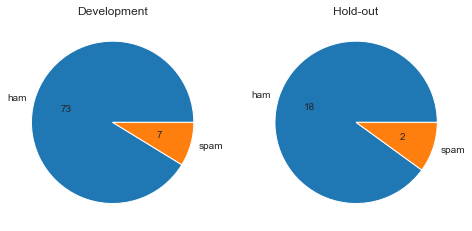

'训练集内容:'

,message
43,What you thinked about me. First time you saw me in class.
62,U can call me now...
3,"Nah I don't think he goes to usf, he lives around here though"
71,For real when u getting on yo? I only need 2 more tickets and one more jacket and I'm done. I already used all my multis.
45,K fyi x has a ride early tomorrow morning but he's crashing at our place tonight


'测试集内容:'

,message
26,K tell me anything about you.
86,Thanks a lot for your wishes on my birthday. Thanks you for making my birthday truly memorable.
2,U dun say so early hor... U c already then say...
55,Ok lar i double check wif da hair dresser already he said wun cut v short. He said will cut until i look nice.
75,Yeah do! Donâ°ÃÃ·t stand to close tho- youâ°ÃÃ·ll catch something!


训练集形状（内容/标签）:  (80,) (80,)
测试集形状（内容/标签）:  (20,) (20,)


In [85]:
# 尝试分割（默认100数据）
split_dataset(df, isShow=True);

In [89]:
import re

# N_data = 1000
N_data = df.shape[0]
N_epochs = 1  # epochs
print("处理数据的数量: ", N_data)
print("训练轮数: ", N_epochs)

np.random.seed(seed=20222022)  # Seed确保可复现

results = pd.DataFrame(columns=['Epoch', 'Encoder', 'Classifier', 'Acc', 'BAcc', 'Prec', 'Recall', 'F1'])
results_test = pd.DataFrame(columns=['Epoch', 'Encoder', 'Classifier', 'Acc', 'BAcc', 'Prec', 'Recall', 'F1'])

for epoch in range(N_epochs):

    print("\n\n------------ Epoch: %d ------------" % (epoch + 1))
    # 8：2划分训练集和测试集
    Train, Test, y_Train, y_Test = split_dataset(df, N_data, isShow=False)

    print("\n\n------------ 训练数据编码中...--------")
    bow_vecs = bow.fit_transform(Train)
    print("\n\nBoW编码...完成！")
    tfidf_vecs = tfidf.fit_transform(Train)
    print("\n\nTFIDF编码...完成！")
    bert_vecs = bert_transform(Train, model)
    print("\n\nBERT编码...完成!\n")

    spam_vecs = defaultdict(list)
    spam_vecs["BoW"] = bow_vecs.todense().A
    spam_vecs["TFIDF"] = tfidf_vecs.todense().A
    spam_vecs["BERT"] = np.array(bert_vecs)
    print("\n\n------------ 训练数据编码完成！--------")

    # 每个编码器在每个分类器的表现
    for key in spam_vecs.keys():
        # 3：1划分训练集和验证集
        X_train, X_valid, y_train, y_valid = train_test_split(spam_vecs[key], y_Train,
                                                              test_size=0.25)
        for clf in classifiers:
            acc, bacc, prec, recall, f1 = train_test_clf(clf, X_train, y_train, X_valid, y_valid,
                                                         "[%s %s] " % (key, type(clf).__name__), isShow=False)
            # 记录评估指标
            results = results.append({'Epoch': epoch, 'Encoder': key,
                                      'Classifier': type(clf).__name__,
                                      'Acc': acc, 'BAcc': bacc,
                                      'Prec': prec, 'Recall': recall,
                                      'F1': f1}, ignore_index=True)
    print("\n\n------------ 测试数据编码中...--------")
    bow_vecs_test = bow.transform(Test)
    print("\n\nBoW编码...完成！")
    tfidf_vecs_test = tfidf.transform(Test)
    print("\n\nTFIDF编码...完成！")
    bert_vecs_test = bert_transform(Test, model)
    print("\n\nBERT编码...完成!\n")

    spam_vecs_test = defaultdict(list)
    spam_vecs_test["BoW"] = bow_vecs_test.todense().A
    spam_vecs_test["TFIDF"] = tfidf_vecs_test.todense().A
    spam_vecs_test["BERT"] = np.array(bert_vecs_test)
    print("\n\n------------ 测试数据编码完成！--------")

    # 在测试集查看模型表现
    for key in spam_vecs_test.keys():
        for clf in classifiers:
            acc, bacc, prec, recall, f1 = test_clf(clf, spam_vecs_test[key], y_Test,
                                                   "[%s %s] " % (key, type(clf).__name__), isShow=False)
            # 记录评估指标
            results_test = results_test.append({
                'Epoch': epoch, 'Encoder': key,
                'Classifier': type(clf).__name__,
                'Acc': acc, 'BAcc': bacc,
                'Prec': prec, 'Recall': recall,
                'F1': f1
            }, ignore_index=True)
# # 打印评估指标
# pprint(results)
print("完成!")

处理数据的数量:  4869
训练轮数:  1


------------ Epoch: 1 ------------


------------ 训练数据编码中...--------


BoW编码...完成！


TFIDF编码...完成！


使用BERT模型编码中... 
.   0
.................................................................................................... 100
.................................................................................................... 200
.................................................................................................... 300
.................................................................................................... 400
.................................................................................................... 500
.................................................................................................... 600
.................................................................................................... 700
.................................................................................................... 800
...........

In [ ]:
# # 保存训练时的评估值结果
# with open('/content/gdrive/MyDrive/SpamDetection/data/model_results.pkl', "wb") as f:
#   pickle.dump(results, f)
# f.close()

In [ ]:
# 保存训练时的评估值结果
with open('D:\GraduationDesign\sms-spam-detector\data\clf_results.pkl', "wb") as f1:
    pickle.dump(results, f1)

In [ ]:
# 保存测试时的评估值结果
with open('D:\GraduationDesign\sms-spam-detector\data\clf_results_test.pkl', "wb") as f2:
    pickle.dump(results_test, f2)

In [ ]:
# # 加载结果
# file = '/content/gdrive/MyDrive/SpamDetection/data/model_results.pkl'

In [ ]:
# 加载结果
results = pickle.load(open(r'D:\GraduationDesign\sms-spam-detector\data\clf_results.pkl', "rb"))

In [ ]:
results_test = pickle.load(open(r'D:\GraduationDesign\sms-spam-detector\data\clf_results_test.pkl', "rb"))

In [90]:
pd.options.display.float_format = '{:,.1%}'.format
pd.options.display.max_rows = None

print("\n\n>>>>>分类实验: ", results.shape)

# 打印统计数据
display(results.groupby(['Encoder']).describe())

aggregations = {
    'BAcc': [lambda x: "%.2f+-%.2f%%" % (np.mean(x) * 100, np.std(x) * 100)],  # 平均值+-标准差
    'Acc': [lambda x: "%.2f+-%.2f%%" % (np.mean(x) * 100, np.std(x) * 100)],
    'Recall': [lambda x: "%.2f+-%.2f%%" % (np.mean(x) * 100, np.std(x) * 100)],
    'Prec': [lambda x: "%.2f+-%.2f%%" % (np.mean(x) * 100, np.std(x) * 100)],
}

# 打印聚合的统计数据
display(results.groupby(['Encoder', 'Classifier']).agg(aggregations))
display(results_test.groupby(['Encoder', 'Classifier']).agg(aggregations))



>>>>>分类实验:  (21, 8)


Acc                                            BAcc        ...  \
         count  mean  std   min   25%   50%   75%   max  count  mean  ...   
Encoder                                                               ...   
BERT    700.0% 98.0% 1.3% 95.1% 98.1% 98.3% 98.7% 98.8% 700.0% 92.4%  ...   
BoW     700.0% 92.8% 8.8% 73.5% 93.4% 96.6% 97.3% 97.8% 700.0% 83.5%  ...   
TFIDF   700.0% 92.2% 7.9% 75.1% 92.1% 95.8% 96.6% 97.3% 700.0% 78.9%  ...   

        Recall           F1                                            
           75%   max  count  mean   std   min   25%   50%   75%   max  
Encoder                                                                
BERT     89.5% 91.8% 700.0% 90.4%  6.1% 76.9% 90.8% 91.9% 94.0% 94.4%  
BoW      83.3% 87.0% 700.0% 71.4% 24.2% 31.2% 60.1% 84.4% 87.3% 89.3%  
TFIDF    80.8% 82.7% 700.0% 64.3% 25.7% 17.5% 53.9% 75.7% 81.2% 86.6%  

[3 rows x 40 columns]

BAcc           Acc        Recall  \
                                    <lambda>      <lambda>      <lambda>   
Encoder Classifier                                                         
BERT    DecisionTreeClassifier  85.32+-0.00%  95.07+-0.00%  72.73+-0.00%   
        GaussianNB              95.74+-0.00%  98.77+-0.00%  91.82+-0.00%   
        KNeighborsClassifier    93.46+-0.00%  98.25+-0.00%  87.27+-0.00%   
        LinearSVC               94.49+-0.00%  98.67+-0.00%  89.09+-0.00%   
        LogisticRegression      91.82+-0.00%  98.15+-0.00%  83.64+-0.00%   
        MLPClassifier           91.36+-0.00%  98.05+-0.00%  82.73+-0.00%   
        SVC                     94.94+-0.00%  98.77+-0.00%  90.00+-0.00%   
BoW     DecisionTreeClassifier  83.45+-0.00%  95.79+-0.00%  67.59+-0.00%   
        GaussianNB              79.43+-0.00%  73.51+-0.00%  87.04+-0.00%   
        KNeighborsClassifier    59.26+-0.00%  90.97+-0.00%  18.52+-0.00%   
        LinearSVC               91.38+-0.00%  96.92+-0.00%  84.26+-0.00%   
        LogisticRegression      90.68+-0.00%  97.84+-0.00%  81.48+-0.00%   
        MLPClassifier           90.22+-0.00%  97.74+-0.00%  80.56+-0.00%   
        SVC                     90.40+-0.00%  96.61+-0.00%  82.41+-0.00%   
TFIDF   DecisionTreeClassifier  77.50+-0.00%  93.84+-0.00%  56.73+-0.00%   
        GaussianNB              78.42+-0.00%  75.05+-0.00%  82.69+-0.00%   
        KNeighborsClassifier    54.81+-0.00%  90.35+-0.00%   9.62+-0.00%   
        LinearSVC               90.04+-0.00%  97.33+-0.00%  80.77+-0.00%   
        LogisticRegression      80.71+-0.00%  95.79+-0.00%  61.54+-0.00%   
        MLPClassifier           80.71+-0.00%  95.79+-0.00%  61.54+-0.00%   
        SVC                     90.04+-0.00%  97.33+-0.00%  80.77+-0.00%   

                                         Prec  
                                     <lambda>  
Encoder Classifier                             
BERT    DecisionTreeClassifier   81.63+-0.00%  
        GaussianNB               97.12+-0.00%  
        KNeighborsClassifier     96.97+-0.00%  
        LinearSVC                98.99+-0.00%  
        LogisticRegression      100.00+-0.00%  
        MLPClassifier           100.00+-0.00%  
        SVC                      99.00+-0.00%  
BoW     DecisionTreeClassifier   92.41+-0.00%  
        GaussianNB               27.81+-0.00%  
        KNeighborsClassifier    100.00+-0.00%  
        LinearSVC                87.50+-0.00%  
        LogisticRegression       98.88+-0.00%  
        MLPClassifier            98.86+-0.00%  
        SVC                      86.41+-0.00%  
TFIDF   DecisionTreeClassifier   79.73+-0.00%  
        GaussianNB               27.65+-0.00%  
        KNeighborsClassifier    100.00+-0.00%  
        LinearSVC                93.33+-0.00%  
        LogisticRegression       98.46+-0.00%  
        MLPClassifier            98.46+-0.00%  
        SVC                      93.33+-0.00%

BAcc           Acc        Recall  \
                                    <lambda>      <lambda>      <lambda>   
Encoder Classifier                                                         
BERT    DecisionTreeClassifier  88.78+-0.00%  96.00+-0.00%  79.31+-0.00%   
        GaussianNB              97.26+-0.00%  98.46+-0.00%  95.69+-0.00%   
        KNeighborsClassifier    95.40+-0.00%  98.46+-0.00%  91.38+-0.00%   
        LinearSVC               97.61+-0.00%  99.08+-0.00%  95.69+-0.00%   
        LogisticRegression      95.14+-0.00%  98.67+-0.00%  90.52+-0.00%   
        MLPClassifier           95.14+-0.00%  98.67+-0.00%  90.52+-0.00%   
        SVC                     97.61+-0.00%  99.08+-0.00%  95.69+-0.00%   
BoW     DecisionTreeClassifier  51.40+-0.00%  87.27+-0.00%   4.31+-0.00%   
        GaussianNB              46.71+-0.00%  79.67+-0.00%   3.45+-0.00%   
        KNeighborsClassifier    47.35+-0.00%  80.80+-0.00%   3.45+-0.00%   
        LinearSVC               46.84+-0.00%  74.64+-0.00%  10.34+-0.00%   
        LogisticRegression      50.14+-0.00%  84.39+-0.00%   5.17+-0.00%   
        MLPClassifier           50.26+-0.00%  84.60+-0.00%   5.17+-0.00%   
        SVC                     46.21+-0.00%  74.85+-0.00%   8.62+-0.00%   
TFIDF   DecisionTreeClassifier  51.40+-0.00%  87.27+-0.00%   4.31+-0.00%   
        GaussianNB              46.18+-0.00%  77.41+-0.00%   5.17+-0.00%   
        KNeighborsClassifier    46.55+-0.00%  77.41+-0.00%   6.03+-0.00%   
        LinearSVC               48.83+-0.00%  86.04+-0.00%   0.00+-0.00%   
        LogisticRegression      50.00+-0.00%  88.09+-0.00%   0.00+-0.00%   
        MLPClassifier           50.00+-0.00%  88.09+-0.00%   0.00+-0.00%   
        SVC                     48.54+-0.00%  85.52+-0.00%   0.00+-0.00%   

                                        Prec  
                                    <lambda>  
Encoder Classifier                            
BERT    DecisionTreeClassifier  85.98+-0.00%  
        GaussianNB              91.74+-0.00%  
        KNeighborsClassifier    95.50+-0.00%  
        LinearSVC               96.52+-0.00%  
        LogisticRegression      98.13+-0.00%  
        MLPClassifier           98.13+-0.00%  
        SVC                     96.52+-0.00%  
BoW     DecisionTreeClassifier  27.78+-0.00%  
        GaussianNB               4.44+-0.00%  
        KNeighborsClassifier     5.06+-0.00%  
        LinearSVC                7.74+-0.00%  
        LogisticRegression      12.50+-0.00%  
        MLPClassifier           13.04+-0.00%  
        SVC                      6.71+-0.00%  
TFIDF   DecisionTreeClassifier  27.78+-0.00%  
        GaussianNB               5.17+-0.00%  
        KNeighborsClassifier     5.93+-0.00%  
        LinearSVC                0.00+-0.00%  
        LogisticRegression       0.00+-0.00%  
        MLPClassifier            0.00+-0.00%  
        SVC                      0.00+-0.00%